Load packages

In [1]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
from datetime import date
import ast
import random
import matplotlib.pyplot as plt

Define DA model with Flexibility Options

In [2]:
DAFOmodel = pyo.AbstractModel()

#Sets
DAFOmodel.S = pyo.RangeSet(1, 5) #Set of scenarios
DAFOmodel.G = pyo.RangeSet(1, 5) #Set of generators
DAFOmodel.R = pyo.RangeSet(1, 4) #Set of tiers

#Parameters
DAFOmodel.VC = pyo.Param(DAFOmodel.G) #Variable cost
DAFOmodel.VCUP = pyo.Param(DAFOmodel.G) #Variable cost
DAFOmodel.VCDN = pyo.Param(DAFOmodel.G) #Variable cost
DAFOmodel.CAP = pyo.Param(DAFOmodel.G) #Capacity
DAFOmodel.REDA=pyo.Param(within=pyo.NonNegativeIntegers) #Maximum DA RE
DAFOmodel.DEMAND=pyo.Param(within=pyo.NonNegativeIntegers) #Electricty demand
DAFOmodel.D1=pyo.Param(within=pyo.NonNegativeIntegers) #linear cost coefficient for demand slack variable
DAFOmodel.D2=pyo.Param(within=pyo.NonNegativeIntegers) #quadratic cost coefficient for demand slack variable

#Parameters specific to the FO
DAFOmodel.RR= pyo.Param(DAFOmodel.G) #Ramp rate
DAFOmodel.RE = pyo.Param(DAFOmodel.S) #Renewable generation at each scenario [FO buyer]
DAFOmodel.PEN=pyo.Param(within=pyo.NonNegativeIntegers) #Penalty for inadequate flexibility up [FO buyer]
DAFOmodel.PENDN=pyo.Param(within=pyo.NonNegativeIntegers) #Penalty for inadequate flexibility down [FO buyer]
DAFOmodel.smallM=pyo.Param(within=pyo.NonNegativeReals) #Parameter that helps choose among alternative optima
DAFOmodel.probTU=pyo.Param(DAFOmodel.R) #probability of exercise FO up
DAFOmodel.probTD=pyo.Param(DAFOmodel.R) #probability of exercise FO dn

# Variables
DAFOmodel.d = pyo.Var(domain=pyo.NonNegativeReals) #slack for demand that makes demand elastic and helps us with degeneracy
DAFOmodel.xDA=pyo.Var(DAFOmodel.G, domain=pyo.NonNegativeReals) #DA energy schedule for generators
DAFOmodel.rgDA=pyo.Var(domain=pyo.NonNegativeReals) #DA energy schedule for renewables
DAFOmodel.du= pyo.Var(DAFOmodel.S)

#Variables [FO]
DAFOmodel.hsu  = pyo.Var(DAFOmodel.R, DAFOmodel.G, domain=pyo.NonNegativeReals) #supply FO up
DAFOmodel.hsd  = pyo.Var(DAFOmodel.R, DAFOmodel.G, domain=pyo.NonNegativeReals) #supply FO down
DAFOmodel.hdu  = pyo.Var(DAFOmodel.R, domain=pyo.NonNegativeReals) #demand FO up
DAFOmodel.hdd  = pyo.Var(DAFOmodel.R, domain=pyo.NonNegativeReals)  #demand FO down
DAFOmodel.sdu  = pyo.Var(DAFOmodel.R, domain=pyo.NonNegativeReals)  #Self-supply FO up [FO buyer]
DAFOmodel.sdd  = pyo.Var(DAFOmodel.R, domain=pyo.NonNegativeReals) #Self-supply FO down [FO buyer]
DAFOmodel.y    = pyo.Var(DAFOmodel.S, domain=pyo.NonNegativeReals) #Auxiliary variable



#Define objective function
def obj_expression(m):
    return sum(m.VC[g]*m.xDA[g] for g in m.G)+sum(m.probTU[r]*m.VCUP[g]*m.hsu[r,g] for g in m.G for r in m.R)\
+sum(m.probTU[r]*m.PEN*m.sdu[r]  for r in m.R)-sum(m.probTD[r]*(m.VCDN[g])*m.hsd[r,g] for g in m.G for r in m.R)\
-sum(m.probTD[r]*m.PENDN*m.sdd[r] for r in m.R)+sum(m.y[s] for s in m.S)*m.smallM \
+sum(0.2*m.D1*(m.d+m.du[s])  for s in m.S) +0.2*m.D2*sum((m.d+m.du[s])*(m.d+m.du[s]) for s in m.S  )\
###### create symmetry with demand curve in real-time, #+ m.D2 *m.d*m.d

DAFOmodel.OBJ = pyo.Objective(rule=obj_expression)

#Define constraints - Numbering of constraints follows paper
def DA_energy_balance(model):
    return sum(model.xDA[g] for g in model.G)+ model.rgDA+model.d == model.DEMAND
DAFOmodel.Con3 = pyo.Constraint(expr=DA_energy_balance) 

def DA_flexup_balance(model,r):
    return sum(model.hsu[r,g] for g in model.G) == model.hdu[r]
DAFOmodel.Con4UP = pyo.Constraint(DAFOmodel.R, rule=DA_flexup_balance)

def DA_flexdn_balance(model,r):
    return sum(model.hsd[r,g] for g in model.G) == model.hdd[r]
DAFOmodel.Con4DN = pyo.Constraint(DAFOmodel.R, rule=DA_flexdn_balance)

def DA_flex_demand(model,s):
    return -model.du[s]+sum(model.hdd[r]+model.sdd[r] for r in model.R if r<=s-1 )-sum(model.hdu[r]+model.sdu[r] for r in model.R if r>=s )==model.RE[s]-model.rgDA
DAFOmodel.Con6 = pyo.Constraint(DAFOmodel.S, rule=DA_flex_demand)

def DA_flex_demand_bound(model,s):
    return sum(model.hdd[r]+model.sdd[r] for r in model.R if r<=s-1 )+sum(model.hdu[r]+model.sdu[r] for r in model.R if r>=s )<=model.y[s]
DAFOmodel.Con7 = pyo.Constraint(DAFOmodel.S, rule=DA_flex_demand_bound)

def Y2(model,s):
    return model.y[s]>=model.rgDA-model.RE[s]
DAFOmodel.Con8  = pyo.Constraint(DAFOmodel.S, rule=Y2)  

def Y1(model,s):
    return model.y[s]>=model.RE[s]-model.rgDA
DAFOmodel.Con9 = pyo.Constraint(DAFOmodel.S, rule=Y1)  
    
def RRUP(model,g):
    return sum(model.hsu[r,g] for r in model.R)<=model.RR[g]
DAFOmodel.Con10up = pyo.Constraint(DAFOmodel.S, rule=RRUP)  

def RRDN(model,g):
    return sum(model.hsd[r,g] for r in model.R)<=model.RR[g]
DAFOmodel.Con10dn = pyo.Constraint(DAFOmodel.S, rule=RRDN) 

def DA_capacity_cons(model, g):
    return model.xDA[g] +sum(model.hsu[r,g] for r in model.R)<= model.CAP[g]
DAFOmodel.Con11 = pyo.Constraint(DAFOmodel.G, rule=DA_capacity_cons)

def DA_down_cons(model, g):
    return  sum(model.hsd[r,g] for r in model.R)<= model.xDA[g]
DAFOmodel.Con12= pyo.Constraint(DAFOmodel.G, rule=DA_down_cons)

#Record duals
DAFOmodel.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

Stochastic Program that is used to simulate the impact of DA decisions on RT

In [3]:
RTsim = pyo.AbstractModel()
#Sets
RTsim.S = pyo.RangeSet(1, 5)
RTsim.G = pyo.RangeSet(1, 5)

#Parameters
RTsim.VC = pyo.Param(RTsim.G)
RTsim.VCUP = pyo.Param(RTsim.G)
RTsim.VCDN = pyo.Param(RTsim.G)
RTsim.CAP = pyo.Param(RTsim.G)
RTsim.RR= pyo.Param(RTsim.G)

RTsim.prob=pyo.Param(RTsim.S)
RTsim.RE = pyo.Param(RTsim.S)
RTsim.DEMAND=pyo.Param(within=pyo.NonNegativeIntegers)
RTsim.D1=pyo.Param(within=pyo.NonNegativeIntegers)
RTsim.D2=pyo.Param(within=pyo.NonNegativeIntegers)
RTsim.xDA=pyo.Param(RTsim.G, domain=pyo.NonNegativeReals)
RTsim.REDA=pyo.Param( domain=pyo.NonNegativeReals)
RTsim.PEN=pyo.Param(within=pyo.NonNegativeIntegers)
RTsim.PENDN=pyo.Param()
RTsim.DAdr=pyo.Param()

# Variables
RTsim.xup = pyo.Var(RTsim.S, RTsim.G, domain=pyo.NonNegativeReals)
RTsim.xdn = pyo.Var(RTsim.S, RTsim.G, domain=pyo.NonNegativeReals)
RTsim.d= pyo.Var(RTsim.S)
RTsim.rgup = pyo.Var(RTsim.S, domain=pyo.NonNegativeReals)
RTsim.rgdn = pyo.Var(RTsim.S, domain=pyo.NonNegativeReals)
RTsim.sdup = pyo.Var(RTsim.S, domain=pyo.NonNegativeReals)
RTsim.sddn = pyo.Var(RTsim.S, domain=pyo.NonNegativeReals)

#Objective
def obj_expression(m):
    return sum(m.prob[s]*(m.VCUP[g]*m.xup[s,g]-m.VCDN[g]*m.xdn[s,g]) for g in m.G for s in m.S)-m.PENDN*sum(m.prob[s]*m.sdup[s] for s in m.S)+m.PEN*sum(m.prob[s]*m.sddn[s] for s in m.S)\
+sum(m.prob[s]*(m.D1*(m.DAdr+m.d[s])+m.D2*(m.DAdr+m.d[s])*(m.DAdr+m.d[s])) for s in m.S)\
-sum(m.prob[s]*(m.D1*(m.DAdr)+m.D2*(m.DAdr)*(m.DAdr)) for s in m.S)
RTsim.OBJ = pyo.Objective(rule=obj_expression)

#Constraints
def RT_energy_balance(model,s):
    return sum(model.xup[s,g]-model.xdn[s,g] for g in model.G)+ model.rgup[s]-model.rgdn[s] +model.d[s]== 0

def RT_RE_availability(model,s):
    return model.rgup[s]-model.rgdn[s]+model.sdup[s]-model.sddn[s] ==model.RE[s]-model.REDA 

def RT_ramp_up(model,s,g):
    return model.xup[s,g] <=model.RR[g]

def RT_ramp_dn(model,s,g):
    return model.xdn[s,g] <= model.RR[g]
def RT_capacity_cons(model,s, g):
    return model.xDA[g]+model.xup[s,g] <= model.CAP[g]

def RT_capacity_min(model,s, g):
    return model.xDA[g]-model.xdn[s,g] >=0

# Numbering of constraints follows the RT problem
RTsim.Con3 = pyo.Constraint(RTsim.S, rule=RT_energy_balance)
RTsim.Con4 = pyo.Constraint(RTsim.S, rule= RT_RE_availability)
RTsim.Con5up = pyo.Constraint(RTsim.S,RTsim.G, rule=RT_ramp_up)
RTsim.Con5dn = pyo.Constraint(RTsim.S, RTsim.G,rule=RT_ramp_dn)
RTsim.Con6 = pyo.Constraint(RTsim.S,RTsim.G, rule=RT_capacity_cons)
RTsim.Con7 = pyo.Constraint(RTsim.S,RTsim.G, rule=RT_capacity_min)

#Record duals
RTsim.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

Use CPLEX to solve the problem [quadratic objective function due to elastic demand]

In [4]:
opt = pyo.SolverFactory('cplex',executable='C:/Program Files/IBM/ILOG/CPLEX_Studio2211/cplex/bin/x64_win64/cplex')


Read input data from excel

In [5]:
input_data=pd.read_csv('Input_files/Experiment_vcupdnrandom.csv',index_col=0)
Summary_cost=pd.DataFrame()
Summary_price_convergence=[]
Summary_up_convergence=[]
Summary_dn_convergence=[]
Summary_10up=[]
Summary_10dn=[]
Summary_11=[]
Summary_12=[]
Summary_su=[]
Summary_sd=[]
xup_diff=[]
xdn_diff=[]
rgupdn_diff=[]
d_diff=[]
sd_diff=[]
Summary_demand=pd.DataFrame()
random.seed(123)
for l in range(0,1000):
  
        for m in [input_data.columns[0]]:
            dataDA=input_data[m].to_dict()
            for k in range(0,len(input_data[m])):
                    dataDA[input_data.index[k]]=ast.literal_eval(input_data[m][input_data.index[k]])
            for gen in range(1,6):
                    dataDA["RR"][gen]=round(dataDA["CAP"][gen]*random.uniform(0, 1),2)
                    dataDA["VCUP"][gen]=round(dataDA["VC"][gen]*random.uniform(1, 2),2)
                    dataDA["VCDN"][gen]=round(dataDA["VC"][gen]*random.uniform(0, 1),2)
            dataDA["smallM"]={None: 0}
            dataDA = {None: dataDA}
  
        i = DAFOmodel.create_instance(dataDA)
        opt.solve(i)
        #Values to pass from DA to RT module
        Energy=pd.DataFrame()
        E_grid_data = {(G): v.value for (G), v in i.xDA.items()}
        Energy['en']= pd.DataFrame.from_dict(E_grid_data, orient="index", columns=["en"])
        temp=i.rgDA.value
        Total=pd.DataFrame()
        Total.at['cost','DA']=sum(np.multiply(np.array([i.VC[k] for k in i.G]),np.array([i.xDA[g].value for g in i.G])))
        Total.at['price','DA']=i.dual[i.Con3]
        E_grid_data = {(R): v.value for (R), v in i.hdu.items()}
        demand = pd.DataFrame.from_dict(E_grid_data, orient="index", columns=["hdu"])
        E_grid_data = {(R): v.value for (R), v in i.hdd.items()}
        demand ['hdd']= pd.DataFrame.from_dict(E_grid_data, orient="index", columns=["hdd"])
        E_grid_data = {(R,G): v.value for (R,G), v in i.hsu.items()}
        df = pd.DataFrame.from_dict(E_grid_data, orient="index", columns=["hsu"])
        E_grid_data = {(R,G): v.value for (R,G), v in i.hsd.items()}
        df ['hsd']= pd.DataFrame.from_dict(E_grid_data, orient="index", columns=["hsd"])
        df['R']=[df.index[i][0] for i in range(0,len(df))]
        df['G']=[df.index[i][1] for i in range(0,len(df))]
        Prices=pd.DataFrame()
        Prices['up']=[i.dual[i.Con4UP[r]] for r in i.R]
        Prices['down']=[i.dual[i.Con4DN[r]] for r in i.R]
        Gross_margins=pd.DataFrame()
        Gross_margins["en"]=np.multiply(i.dual[i.Con3]-np.array([i.VC[k] for k in i.G]), Energy['en'])
        #Gross_margins.at[0,"en"]=i.rgDA.value*i.dual[i.Con3]
        for tier in range(1,5):
            temp2=np.multiply(df["hsu"].loc[df["R"]==tier].reset_index(drop=True), Prices.at[tier-1,"up"]-np.multiply(np.array([i.VCUP[k] for k in i.G]),i.probTU[tier]))
            temp2.index=range(1,6)
            Gross_margins["up"+str(tier)]=temp2
            temp2=np.multiply(df["hsd"].loc[df["R"]==tier].reset_index(drop=True), Prices.at[tier-1,"down"]+np.multiply(np.array([i.VCDN[k] for k in i.G]),i.probTD[tier]))
            temp2.index=range(1,6)
            Gross_margins["down"+str(tier)]=temp2
            
        dataRT = {None:{
            'RE': dataDA[None]["RE"],
            'CAP': dataDA[None]["CAP"],
            'VC': dataDA[None]["VC"],
            'VCUP': dataDA[None]["VCUP"],
            'VCDN': dataDA[None]["VCDN"],
            'DEMAND': dataDA[None]["DEMAND"],
            'D1': dataDA[None]["D1"],
            'D2': dataDA[None]["D2"],
            'prob':{1: 0.2, 2:0.2, 3:0.2, 4:0.2, 5:0.2},
              'RR': dataDA[None]["RR"],
            'xDA':Energy['en'],
             'PEN':dataDA[None]["PEN"],
             'PENDN':dataDA[None]["PENDN"],
             'REDA':{None: temp},
            'DAdr': {None: i.d.value}
            }}
        iRT = RTsim.create_instance(dataRT)
        opt.solve(iRT)
        RTmargins=pd.DataFrame()
        for s in iRT.S:  
            RTmargins[s]=(np.multiply(iRT.dual[iRT.Con3[s]]-iRT.prob[s]*np.array([iRT.VCUP[k] for k in iRT.G]),np.array([iRT.xup[s,k].value for k in i.G])))+(np.multiply(-iRT.dual[iRT.Con3[s]]+iRT.prob[s]*np.array([iRT.VCDN[k] for k in iRT.G]),np.array([iRT.xdn[s,k].value for k in i.G])))
        RTmargins.index=range(1,len(RTmargins)+1)
        RTpayoffs=pd.DataFrame()
        for s in iRT.S: 
            if s<5:
                RTpayoffs["UP"+str(s)]=-(iRT.dual[iRT.Con3[s]]*df[["hsu","G"]].loc[df["R"]>=s].groupby("G").sum().values.transpose()-np.multiply(iRT.prob[s]*np.array([iRT.VCUP[k] for k in iRT.G]),df[["hsu","G"]].loc[df["R"]>=s].groupby("G").sum().values.transpose()))[0]
            if s>1:
                 RTpayoffs["DN"+str(s)]=(iRT.dual[iRT.Con3[s]]*df[["hsd","G"]].loc[df["R"]<s].groupby("G").sum().values.transpose()-np.multiply(iRT.prob[s]*np.array([iRT.VCDN[k] for k in iRT.G]),df[["hsd","G"]].loc[df["R"]<s].groupby("G").sum().values.transpose()))[0]
        RTpayoffs.index=range(1,len(RTpayoffs)+1)
        for s in i.S:
           Total.at['cost',s]=iRT.prob[s]*(sum(np.multiply(np.array([i.VCUP[k] for k in i.G]),np.array([iRT.xup[s,g].value for g in iRT.G])))+sum(np.multiply(np.array([i.VCDN[k] for k in i.G]),np.array([-iRT.xdn[s,g].value for g in iRT.G]))))
           Total.at['price',s]=iRT.dual[iRT.Con3[s]]
           Total.at['unmet_demand',s]=iRT.prob[s]*(iRT.D1*iRT.d[s].value+iRT.D2*iRT.d[s].value*iRT.d[s].value)
           Total.at['curtail cost',s]=iRT.prob[s]*(iRT.PENDN*iRT.sdup[s].value)
        price_convergence=Total.at['price','DA']-Total[Total.columns[1:]].loc['price'].sum()
        premium_convergence=pd.DataFrame()
        premium_convergence['UP']=Gross_margins[Gross_margins.columns[Gross_margins.columns.str.startswith('up')]].sum(axis=1)+RTpayoffs[RTpayoffs.columns[RTpayoffs.columns.str.startswith('UP')]].sum(axis=1)
        premium_convergence['DN']=Gross_margins[Gross_margins.columns[Gross_margins.columns.str.startswith('down')]].sum(axis=1)+RTpayoffs[RTpayoffs.columns[RTpayoffs.columns.str.startswith('DN')]].sum(axis=1)
        premiums=Gross_margins[Gross_margins.columns[Gross_margins.columns.str.startswith('up')]].sum().sum()+Gross_margins[Gross_margins.columns[Gross_margins.columns.str.startswith('down')]].sum().sum()
        premium_convergence.index.name='Generator'
        premium_convergence.index=premium_convergence.index+1
        Total_margin=pd.DataFrame()
        for k in range(1,6):
             Total_margin[k]=iRT.prob[k]*Gross_margins.sum(axis=1)+RTmargins[k]+RTpayoffs[RTpayoffs.columns[RTpayoffs.columns.str.endswith(str(k))]].sum(axis=1)
             Total_margin.at['RE',k]=(iRT.dual[iRT.Con3[k]]*(iRT.rgup[k].value-iRT.rgdn[k].value)) +iRT.prob[k]*temp*i.dual[i.Con3]-iRT.prob[k]*premiums
             if k>1:
                Total_margin.at['RE',k]=Total_margin.at['RE',k]-RTpayoffs["DN"+str(k)].sum()
             if k<5:
                Total_margin.at['RE',k]=Total_margin.at['RE',k]-RTpayoffs["UP"+str(k)].sum()
             Total_margin.at['DR',k]=iRT.dual[iRT.Con3[k]]*iRT.d[k].value+iRT.prob[k]*i.d.value*i.dual[i.Con3] -iRT.prob[k]*(i.D1*(iRT.d[k].value+i.d.value))-iRT.prob[k]*(i.D2*(iRT.d[k].value+i.d.value)*(iRT.d[k].value+i.d.value))
        writer = pd.ExcelWriter('Test_output_files/FULLY_RANDOM/FO_EXPRANDOM_'+str(l)+"_v"+date.today().strftime("%Y_%m_%d")+'revision.xlsx')      
        round(premium_convergence,2).to_excel(writer,'Premium_convergence')
        round(Total,2).to_excel(writer,'System_metrics')
        round(RTmargins,2).to_excel(writer,'RTmargins')
        round(RTpayoffs,2).to_excel(writer,'RTpayoffs')
        round(Gross_margins,2).to_excel(writer,'Grossmargins')
        round(df,2).to_excel(writer,'FO_supply_AWARDS')
        round(demand,2).to_excel(writer,'FO_demand_AWARDS')
        round(Energy,2).to_excel(writer,'DA_energy')
        round(Total_margin,2).to_excel(writer,'Totalmargins')
        round(Prices,2).to_excel(writer,'Prices')
        pd.DataFrame(dataDA).to_excel(writer,'input_DA')
        pd.DataFrame(dataRT).to_excel(writer,'input_RT')
        writer.close()
        Summary_price_convergence.append(Total.loc['price'].transpose())
        Summary_up_convergence.append([i.hdu[r].value*(i.dual[i.Con4UP[r]] -sum(iRT.dual[iRT.Con3[s]] for s in iRT.S if s<=r)) for r in i.R])
        Summary_dn_convergence.append([i.hdd[r].value*(i.dual[i.Con4DN[r]] +sum(iRT.dual[iRT.Con3[s]] for s in iRT.S if s>=r+1)) for r in i.R])
        Summary_10up.append([(i.dual[i.Con10up[g]]<-0.01)*((i.dual[i.Con10up[g]] +i.dual[i.Con11[g]])*(sum(i.hsu[r,g].value for r in i.R)>0.01)-sum((iRT.dual[iRT.Con5up[s,g]]+iRT.dual[iRT.Con6[s,g]])*(sum(i.hsu[r,g].value for r in i.R if r>=s)>0.01) for s in iRT.S)) for g in i.G])
        Summary_10dn.append([(i.dual[i.Con10dn[g]]<-0.01)*((-i.dual[i.Con10dn[g]]-i.dual[i.Con12[g]])*(sum(i.hsd[r,g].value for r in i.R)>0.01) +sum((iRT.dual[iRT.Con5dn[s,g]]-iRT.dual[iRT.Con7[s,g]])*(sum(i.hsd[r,g].value for r in i.R if r<=s-1)>0.01) for s in iRT.S)) for g in i.G])
        Summary_11.append([(i.dual[i.Con11[g]] +sum(iRT.dual[iRT.Con3[s]] for s in iRT.S)-i.VC[g])*(i.dual[i.Con11[g]]>0.01)*(i.xDA[g].value>0) for g in i.G])
        Summary_12.append([(-i.dual[i.Con12[g]]+sum(iRT.dual[iRT.Con3[s]] for s in iRT.S)-i.VC[g])*(i.dual[i.Con12[g]]>0.01)*(sum(i.hsd[r,g].value for r in i.R)>0.01) for g in i.G])
        Summary_su.append([max(r*(i.hsu[r,g].value>0.01) for r in i.R) for  g in i.G ])
        Summary_sd.append([min(r*((i.hsd[r,g].value>0.1)+1000*(i.hsd[r,g].value<0.1)) for r in i.R) for  g in i.G ])
        xup_diff.append([max([iRT.xup[s,g].value-sum(i.hsu[r,g].value for r in i.R if r>=s ) for g in i.G]) for s in i.S])
        xdn_diff.append([max([iRT.xdn[s,g].value-sum(i.hsd[r,g].value for r in i.R if r<=s-1 ) for g in i.G]) for s in i.S])
        rgupdn_diff.append([iRT.d[s].value+iRT.rgup[s].value-iRT.rgdn[s].value-sum(i.hdd[r].value for r in i.R if r<=s-1 ) +sum(i.hdu[r].value for r in i.R if r>=s ) for s in i.S])
        d_diff.append([(iRT.d[s].value-i.du[s].value) for s in i.S])
        sd_diff.append([iRT.sddn[s].value-iRT.sdup[s].value-sum(i.sdu[r].value for r in i.R if r>=s)+sum(i.sdd[r].value for r in i.R if r<=s-1) for s in iRT.S])

<AxesSubplot:title={'center':'DA-RT energy price convergence'}, xlabel='DA-avg RT price in $/MWh', ylabel='Number of simulations'>

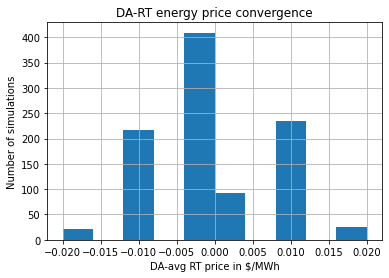

In [6]:
plt.title('DA-RT energy price convergence')
plt.ylabel('Number of simulations')
plt.xlabel('DA-avg RT price in $/MWh')
(round(pd.DataFrame(Summary_price_convergence),2)['DA']-round(pd.DataFrame(Summary_price_convergence),2)[[1,2,3,4,5]].sum(axis=1)).hist()

0.06906220921103563
-0.03438712285397278
0.17556479980189943
-0.08183224092477163
0.20791145672065045
-0.10093438844703884
0.127376284969891
-0.006825045665644135


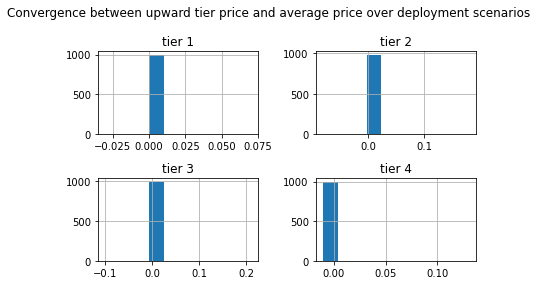

In [7]:
plt.subplots()
plt.suptitle('Convergence between upward tier price and average price over deployment scenarios ')
for k in range(1,5):
    plt.subplot(2,2,k)
    plt.title('tier '+str(k))
    round(pd.DataFrame(Summary_up_convergence),2)[k-1].hist()
    print(max(pd.DataFrame(Summary_up_convergence)[k-1]))
    print(min(pd.DataFrame(Summary_up_convergence)[k-1]))
plt.tight_layout()

0.024442501027660088
-0.016949405437353036
0.1713591650297935
-0.01146261384426638
0.28189174856253135
-0.014582803239269417
0.005375736453890351
-0.01019285418665214


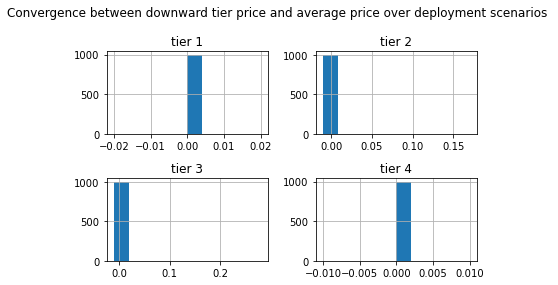

In [8]:
plt.subplots()
plt.suptitle('Convergence between downward tier price and average price over deployment scenarios ')
for k in range(1,5):
    plt.subplot(2,2,k)
    plt.title('tier '+str(k))
    round(pd.DataFrame(Summary_dn_convergence),2)[k-1].hist()
    print(max(pd.DataFrame(Summary_dn_convergence)[k-1]))
    print(min(pd.DataFrame(Summary_dn_convergence)[k-1]))
plt.tight_layout()

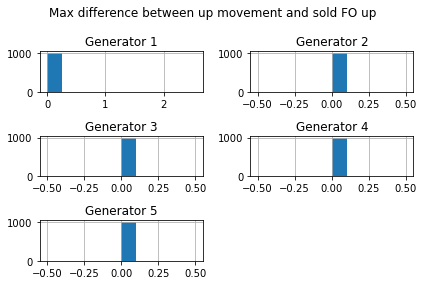

In [9]:
plt.suptitle('Max difference between up movement and sold FO up')
for k in range(0,5):
    plt.subplot(3,2,k+1)
    plt.title('Generator '+str(k+1))
    round(pd.DataFrame(xup_diff),2)[k].hist()
plt.tight_layout()

In [10]:
for k in range(0,5):
    print('The maximum difference between up movement and up FOs supplied for generator '+str(k+1)+' is '+str(round(max(pd.DataFrame(xup_diff)[k]))))
print('Note: run 120 has alternative optima: one generator moves up by 2 but another at same cost also moves down by 2')    

The maximum difference between up movement and up FOs supplied for generator 1 is 3
The maximum difference between up movement and up FOs supplied for generator 2 is 0
The maximum difference between up movement and up FOs supplied for generator 3 is 0
The maximum difference between up movement and up FOs supplied for generator 4 is 0
The maximum difference between up movement and up FOs supplied for generator 5 is 0
Note: run 120 has alternative optima: one generator moves up by 2 but another at same cost also moves down by 2


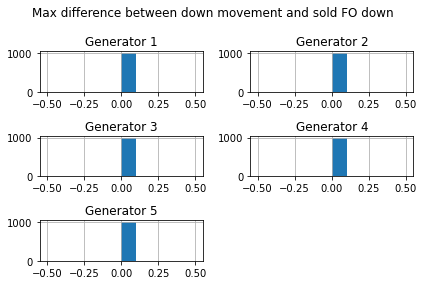

In [11]:
plt.suptitle('Max difference between down movement and sold FO down')
for k in range(0,5):
    plt.subplot(3,2,k+1)
    plt.title('Generator '+str(k+1))
    round(pd.DataFrame(xdn_diff),2)[k].hist()
plt.tight_layout()

In [12]:
for k in range(0,5):
    print('The maximum difference between down movement and down FOs supplied for generator '+str(k+1)+' is '+str(round(max(pd.DataFrame(xdn_diff)[k]))))

The maximum difference between down movement and down FOs supplied for generator 1 is 0
The maximum difference between down movement and down FOs supplied for generator 2 is 0
The maximum difference between down movement and down FOs supplied for generator 3 is 0
The maximum difference between down movement and down FOs supplied for generator 4 is 0
The maximum difference between down movement and down FOs supplied for generator 5 is 0


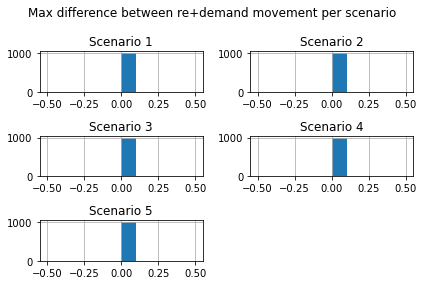

In [13]:
plt.suptitle('Max difference between re+demand movement per scenario')
for k in range(0,5):
    plt.subplot(3,2,k+1)
    plt.title('Scenario '+str(k+1))
    round(pd.DataFrame(rgupdn_diff),2)[k].hist()
plt.tight_layout()

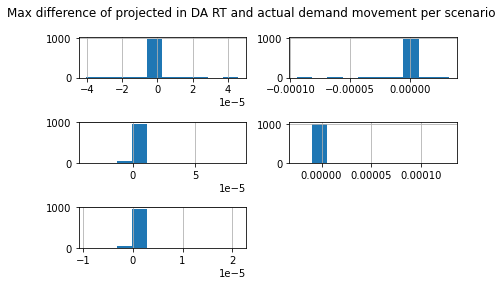

In [14]:
plt.suptitle('Max difference of projected in DA RT and actual demand movement per scenario')
for k in range(0,5):
    plt.subplot(3,2,k+1)
    pd.DataFrame(d_diff)[k].hist()
plt.tight_layout()

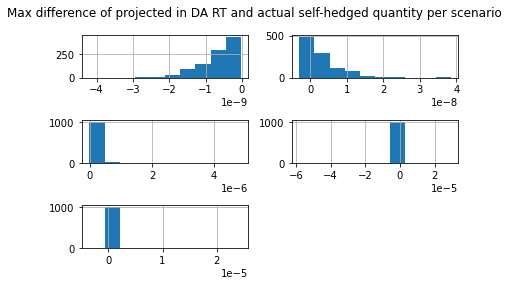

In [15]:
plt.suptitle('Max difference of projected in DA RT and actual self-hedged quantity per scenario')
for k in range(0,5):
    plt.subplot(3,2,k+1)
    pd.DataFrame(sd_diff)[k].hist()
plt.tight_layout()

0.010093433751324099
-0.020791154254524713
0.007155419366840832
-0.008868159736186154
0.003442980406271612
-0.006939548738002177
0.0015135106129354897
-0.006939547945504998
0.0034429601886714067
-0.0009801941798035507


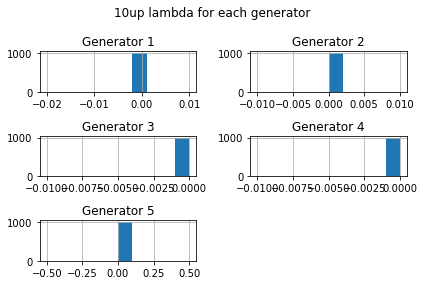

In [16]:
 plt.suptitle('10up lambda for each generator')
for k in range(0,5):
    plt.subplot(3,2,k+1)
    plt.title('Generator '+str(k+1))
    round(pd.DataFrame(Summary_10up),2)[k].hist()
    print(max(pd.DataFrame(Summary_10up)[k]))
    print(min(pd.DataFrame(Summary_10up)[k]))
plt.tight_layout()


0.028217773087266362
-0.001458279732690304
0.0026250413672954664
-0.005442831272857163
0.012864588423212808
-0.00642105374435431
0.00884824755790703
-0.002755019735211306
0.028230529129526616
-0.0005786327165040461


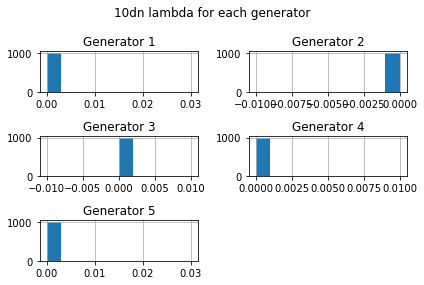

In [17]:
 plt.suptitle('10dn lambda for each generator')
for k in range(0,5):
    plt.subplot(3,2,k+1)
    plt.title('Generator '+str(k+1))
    round(pd.DataFrame(Summary_10dn),2)[k].hist()
    print(max(pd.DataFrame(Summary_10dn)[k]))
    print(min(pd.DataFrame(Summary_10dn)[k]))
plt.tight_layout()


0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
-0.0
-0.0
-0.0


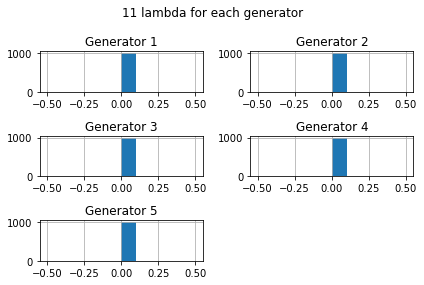

In [18]:
 plt.suptitle('11 lambda for each generator')
for k in range(0,5):
    plt.subplot(3,2,k+1)
    plt.title('Generator '+str(k+1))
    round(pd.DataFrame(Summary_11),2)[k].hist()
    print(max(pd.DataFrame(Summary_11)[k]))
    print(min(pd.DataFrame(Summary_11)[k]))
plt.tight_layout()

0.0
0.0
0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
-0.0


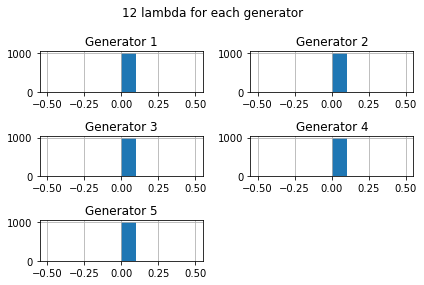

In [19]:
 plt.suptitle('12 lambda for each generator')
for k in range(0,5):
    plt.subplot(3,2,k+1)
    plt.title('Generator '+str(k+1))
    round(pd.DataFrame(Summary_12),2)[k].hist()
    print(max(pd.DataFrame(Summary_12)[k]))
    print(min(pd.DataFrame(Summary_12)[k]))
plt.tight_layout()